In [261]:

import pandas as pd 
import numpy as np 
from utils import * 
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
from src.classifier import Classifier
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.gridspec import GridSpec
import glob
from src import get_genome_id
import os
from scipy.stats import pearsonr
from src.tools import MMSeqs
import dataframe_image as dfi
import warnings
import re
warnings.simplefilter('ignore')

%load_ext autoreload
%autoreload 2

confusion_matrix_map = {'tp':'true positive', 'fp':'false positive', 'tn':'true negative', 'fn':'false negative'}

is_suspect = lambda df : (df.top_hit_product == 'hypothetical protein') & (df.top_hit_evidence_type == 'ab initio prediction')
is_suspect_match = lambda df : is_suspect(df) & (df.category == 'match')
is_intergenic = lambda df : (df.category == 'intergenic')

# TODO: How does the model behave on short sequences versus long sequences? Is it picking up the spurious short ORFs?
# TODO: Find the pairwise distances between AntiFam sequences and model-predicted spurious sequences. 
# TODO: What fraction of each category are predicted spurious?
# TODO: Curious about if some genomes have more conflicts or intergenic sequences than others relative to total genome size. 
#   Is this related to GC content?

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [160]:
# for path in glob.glob('../data/ref/*_ref.csv'):
#     genome_id = get_genome_id(path)
#     prodigal_df = FASTAFile(f'../data/prodigal/{genome_id}_protein.faa').to_df(prodigal_output=True)
#     ref_df = pd.read_csv(path, index_col=0).loc[prodigal_df.index]
#     assert np.all(prodigal_df.index == ref_df.index), 'The indices in the FASTA file do not match the reference output.'
#     print((ref_df.query_seq == 'none').sum(), f'missing sequences in {path}')
#     ref_df['query_seq'] = prodigal_df['seq']
#     ref_df.to_csv(path)

In [161]:
def apply_threshold(results_df:pd.DataFrame, threshold:float=0.5, class_:int=0):
    results_df = results_df.copy()
    results_df['model_label'] = np.where(results_df[f'model_output_{class_}'] >= threshold, class_, int(not class_))
    return results_df 

In [162]:
model_name = 'campylobacterota_v3'

results_df = pd.read_csv('../data/results/prodigal_predict.csv', index_col=0)
results_df = results_df.rename(columns={col:col.replace(model_name, 'model') for col in results_df.columns})
results_df = results_df.merge(pd.read_csv('../data/prodigal.csv', index_col=0), left_index=True, right_index=True)

genome_metadata_df = pd.read_csv('../data/genome_metadata.csv', index_col=0)
results_df['gc_percent'] = results_df.genome_id.map(genome_metadata_df['gc_percent'])

In [264]:
results_df[results_df.category == 'intergenic'].to_csv('../data/results/intergenic_prodigal_predict.csv')

In [163]:
threshold = 0.5
df = pd.DataFrame(index=results_df.category.unique())
df['total'] = results_df.groupby('category').apply(len, include_groups=False)
df['num_predicted_spurious'] = apply_threshold(results_df, threshold=threshold).groupby('category').apply(lambda df : (df.model_label == 0).sum(), include_groups=False)
df['frac_predicted_spurious'] = df.num_predicted_spurious / df.total
df

,total,num_predicted_spurious,frac_predicted_spurious
match,400331,2787,0.006962
intergenic,4372,1576,0.360476
pseudogene,5347,325,0.060782
conflict,877,659,0.751425


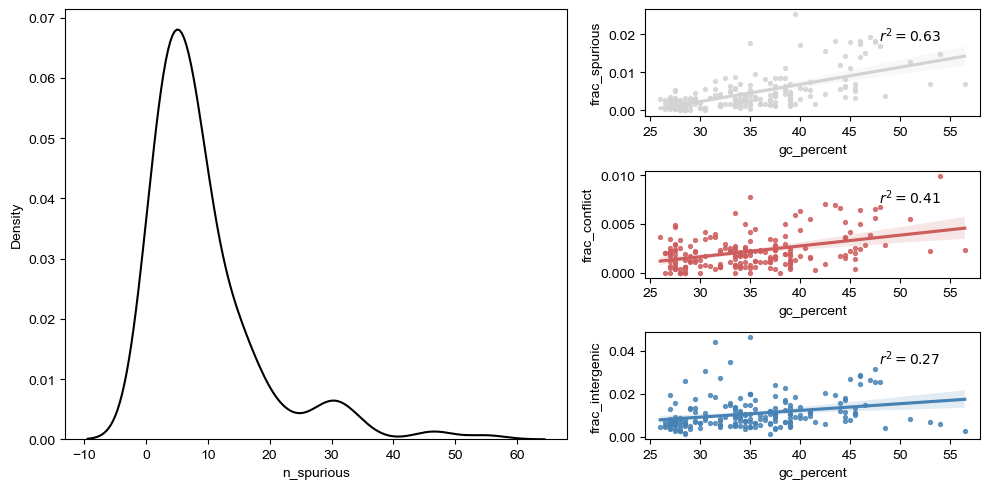

In [164]:
def figure_1(results_df, threshold:float=0.5):

    fig = plt.figure(figsize=(10, 5), layout='tight')
    grid = GridSpec(nrows=3, ncols=2, figure=fig, width_ratios=[0.6, 0.4])
    ax_a = fig.add_subplot(grid[:, 0])
    ax_b = [fig.add_subplot(grid[i, 1]) for i in range(3)]

    results_df = apply_threshold(results_df, threshold=threshold)
    genomes = results_df.groupby('genome_id')

    ax_df = pd.DataFrame(index=results_df['genome_id'].unique())
    ax_df['gc_percent'] = genomes.gc_percent.first()
    ax_df['genome_size'] = genomes.apply(len, include_groups=False)
    ax_df['n_spurious'] = genomes.apply(lambda df : (df.model_label == 0).sum(), include_groups=False)
    ax_df['n_spurious_match'] = genomes.apply(lambda df : ((df.model_label == 0) & (df.category == 'match')).sum(), include_groups=False)
    ax_df['n_spurious_intergenic'] = genomes.apply(lambda df : ((df.model_label == 0) & (df.category == 'intergenic')).sum(), include_groups=False)
    ax_df['n_spurious_conflict'] = genomes.apply(lambda df : ((df.model_label == 0) & (df.category == 'conflict')).sum(), include_groups=False)
    
    ax_df['n_intergenic'] = genomes.apply(lambda df : (df.category == 'intergenic').sum(), include_groups=False)
    ax_df['n_conflict'] = genomes.apply(lambda df : (df.category == 'conflict').sum(), include_groups=False)
    
    ax_df['frac_spurious'] = ax_df.n_spurious / ax_df.genome_size
    ax_df['frac_intergenic'] = ax_df.n_intergenic / ax_df.genome_size
    ax_df['frac_conflict'] = ax_df.n_conflict / ax_df.genome_size

    sns.kdeplot(data=ax_df, x='n_spurious', ax=ax_a, label='spurious', color='black', linestyle='-')
    # sns.kdeplot(data=ax_df, x='n_spurious_match', ax=ax_a, color='darkseagreen', label='spurious match')
    # sns.kdeplot(data=ax_df, x='n_spurious_intergenic', ax=ax_a, color='steelblue', label='spurious intergenic')
    # sns.kdeplot(data=ax_df, x='n_spurious_conflict', ax=ax_a, color='indianred', label='spurious conflict')

    palette = {'frac_spurious':'lightgray', 'frac_conflict':'indianred', 'frac_intergenic':'steelblue'}
    for y, ax in zip(['frac_spurious', 'frac_conflict', 'frac_intergenic'], ax_b):
        sns.regplot(data=ax_df, x='gc_percent', y=y, ax=ax, color=palette.get(y), scatter_kws={'s':8})
        r = pearsonr(ax_df['gc_percent'].values, ax_df[y].values)
        ax.text(0.7, 0.7, f'$r^2={r.statistic:.2f}$', transform=ax.transAxes)

    fig.tight_layout()
    plt.show()

figure_1(results_df, threshold=0.98)

figure_2: 1933 of the spurious matches are suspect.
figure_2: Removing 1933 suspect matches.


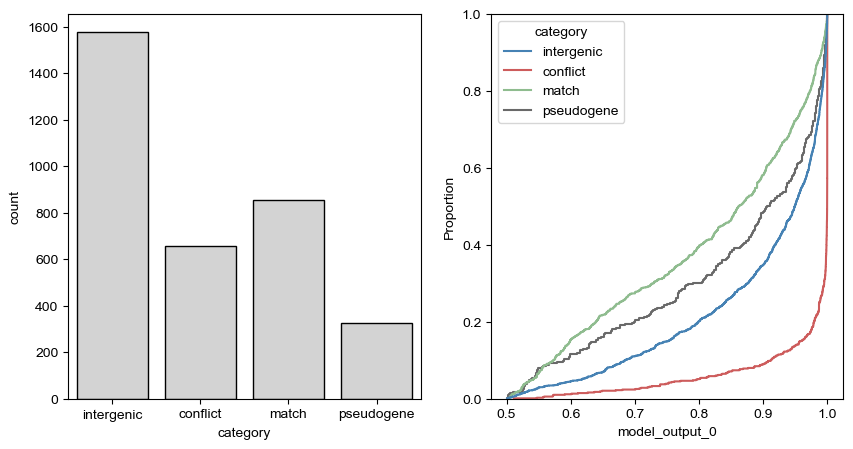

In [ ]:
def figure_2(results_df, threshold:float=0.5, remove_suspect_match:bool=False):
    
    results_df = apply_threshold(results_df, threshold=threshold)
    results_df = results_df[results_df.model_label == 0].copy()
    results_df['suspect_match'] = is_suspect_match(results_df)

    # What fraction of the matches are suspect? These were not included in the training set. 
    # It's unclear if it's actually finding real sequences, or if it's just flagging things it doesn't recognize as spurious.
    print(f'figure_2: {results_df.suspect_match.sum()} of the spurious matches are suspect.')

    if remove_suspect_match:
        print(f'figure_2: Removing {results_df.suspect_match.sum()} suspect matches.')
        results_df = results_df[~results_df.suspect_match].copy()

    fig, (ax_a, ax_b) = plt.subplots(ncols=2, figsize=(10, 5))
    
    ax_a_df = pd.DataFrame(index=results_df.category.unique())
    ax_a_df['category'] = ax_a_df.index
    ax_a_df['count'] = results_df.value_counts('category')

    sns.barplot(data=ax_a_df, ax=ax_a, y='count', x='category', color='lightgray', edgecolor='black')

    ax_b_df = results_df[['model_output_0', 'category']].copy()

    palette = {'intergenic':'steelblue', 'conflict':'indianred', 'match':'darkseagreen', 'pseudogene':'dimgray'}
    sns.ecdfplot(data=ax_b_df, x='model_output_0', hue='category', palette=palette, ax=ax_b)

figure_2(results_df, remove_suspect_match=True)




In [223]:
query_dfs = dict()
query_dfs['suspect_match'] = results_df[is_suspect_match(results_df)].copy().rename(columns={'query_seq':'seq'})
query_dfs['intergenic'] = results_df[results_df.category == 'intergenic'].copy().rename(columns={'query_seq':'seq'})

mmseqs = MMSeqs()

subject_name = 'dataset_train'
subject_df = pd.read_csv(f'../data/{subject_name}.csv', index_col=0)
subject_df = subject_df.drop_duplicates('seq')

align_dfs = dict()
for query_name, query_df in query_dfs.items():
    add_cols = ['genome_id', 'contig_id', 'model_label', 'seq', 'label', 'product', 'category', 'top_hit_protein_id']
    align_df = mmseqs.align(query_df=query_df, subject_df=subject_df, query_name=query_name, output_dir='../data/results/', subject_name=subject_name, sensitivity=7, add_cols=add_cols)

    align_df = align_df.sort_values('e_value')
    align_df = align_df.drop_duplicates('query_id')
    align_dfs[query_name] = align_df 

    print('Query name:', query_name)
    print(f'Number of query sequences:', len(query_df))
    print(f'Number of sequences with alignments in {subject_name}.csv:', len(align_df), f'({100 * len(align_df) / len(query_df):.2f}%)')
    print(f'Number of predicted spurious:', (query_df.model_label == 0).sum())
    print(f'Number of predicted spurious with an alignment:', (align_df.query_model_label == 0).sum())
    print(f'Number of sequences with best alignments to spurious sequences:', (align_df.subject_label == 0).sum())
    print()

Query name: suspect_match
Number of query sequences: 41420
Number of sequences with alignments in dataset_train.csv: 36208 (87.42%)
Number of predicted spurious: 1933
Number of predicted spurious with an alignment: 1520
Number of sequences with best alignments to spurious sequences: 53

Query name: intergenic
Number of query sequences: 4372
Number of sequences with alignments in dataset_train.csv: 2962 (67.75%)
Number of predicted spurious: 1576
Number of predicted spurious with an alignment: 1076
Number of sequences with best alignments to spurious sequences: 16



In [229]:
align_dfs['suspect_match'].subject_product.value_counts()

is_same_genome = lambda df : df.query_genome_id == df.subject_genome_id
is_same_contig = lambda df : np.array([id_.split('.')[0] for id_ in df.query_id]) == df.subject_contig_id
# Compute the traditional sequence identity (with match score 1, gap score 0, and mismatch score 0).
get_sequence_identity_ = lambda df : (df.alignment_length - (df.n_gaps + df.n_mismatches)) / df.alignment_length 

align_df = align_dfs['suspect_match'].copy()
align_df['sequence_identity_'] = get_sequence_identity_(align_df)
align_df[is_same_contig(align_df)] # [['sequence_identity_', 'sequence_identity']]


# Something weird seems to be happening where a lot of the "suspect" sequences have similar sequences in other genomes, 
# and sometimes in the same genome. Sometimes the sequences they aligned to are annotated, though most are hypothetical. 
# It is not clear to me why these sequences were not recognized by PGAP. I did check to make sure there were no bugs in my code,
# and the sequences I have as "suspect matches" are indeed aligned to suspect sequences in the reference genome.

,query_id,subject_id,sequence_identity,alignment_length,n_mismatches,n_gaps,query_alignment_start,query_alignment_stop,subject_alignment_start,subject_alignment_stop,...,query_model_label,query_seq,query_category,query_top_hit_protein_id,subject_genome_id,subject_contig_id,subject_seq,subject_label,subject_product,sequence_identity_
506191,NZ_CP021886.1_279,WP_108910362.1,0.742,1275,317,0,0,1275,0,1230,...,1,MSNKSFYVSPIINSGGGGNNTPIETIKVNVKDYVLNLDFKSNVKTL...,match,WP_108910457.1,GCF_003097575.1,NZ_CP021886,MSNKSFYVSPIINSGGGGNNTPIETIKVNVKDYVLNLDFKSNVKTL...,1,autotransporter outer membrane beta-barrel dom...,0.751373
298874,NZ_CP021886.1_607,WP_108910817.1,0.546,1212,524,0,0,1155,0,1212,...,1,MKNESHNFSLISNLPSSSLFLSFSLITALNTSLVADSWATSGTITL...,match,WP_108910700.1,GCF_003097575.1,NZ_CP021886,MPHSTPIETIKVNVKDYVLNLDFKGNPKPLDSQSLNMNFDYKYSKL...,1,autotransporter outer membrane beta-barrel dom...,0.567657
277960,NZ_AP023046.1_1602,WP_176486428.1,0.922,607,47,0,0,607,0,607,...,1,MLLSLNGLNKGAREYKAEITRQSILKVKNAKDLSQEQKSQIYRDRN...,match,WP_176486515.1,GCF_013374215.1,NZ_AP023046,MLLSLNGLNKGAREYKAEITRQSILKVKNAKDLSQEQKSQIYRDRN...,1,hypothetical protein,0.922570
345355,NZ_CP021886.1_756,WP_108910564.1,0.478,1300,363,0,0,696,0,1300,...,1,MTPSIGNLIIKEGGILQGGDNHSAIAIDANPQHKFTGNIQIEGTLK...,match,WP_108910827.1,GCF_003097575.1,NZ_CP021886,MQNSMLTLTTLIPSGGGGKIMPHSTPIETIKVNVKDYVLNLDFKSN...,1,autotransporter outer membrane beta-barrel dom...,0.720769
393689,NZ_CP014991.1_1287,WP_066389031.1,0.806,1203,207,0,0,1067,0,1203,...,1,MPMGGNIATILNNGTLTGGLTNQEGGSIGTFTHASTTVLDSLTNIG...,match,WP_066389051.1,GCF_001602095.1,NZ_CP014991,MQNLHNNFDLSSITNTGSINELNNASNITITTLTNQTNGRITTLNN...,1,beta strand repeat-containing protein,0.827930
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411897,NZ_CP054052.1_712,WP_083574671.1,0.131,696,145,0,0,696,0,168,...,1,MKKILLSAALCSSLLFANYNDAGTDYTNAITKSFTEESTLQPINTV...,match,WP_071626175.1,GCF_013283835.1,NZ_CP054052,MNYLKAVLKKDHETKIKELKKLIVLGEKLNKNTTPDKKKLEILIER...,1,N-acetylmuramoyl-L-alanine amidase,0.791667
234828,NZ_CP041070.1_1177,WP_129082329.1,0.345,44,15,0,0,44,0,24,...,1,MLKNKKLILKVMYYYNLIKAKKIDNYLLIIGILGVVIGLYFSIPII...,match,WP_129081888.1,GCF_006459125.1,NZ_CP041070,MKIFNYRLVIFILSIIFGIVFSIPSFLQTETGKKISLGLDLQGGLH...,1,protein translocase subunit SecD,0.659091
28991,NZ_CP100595.1_1003,WP_254577883.1,0.156,251,76,0,0,91,0,251,...,1,MKDKIVFYLAIWGALLSSILGYFQIQEYLTPKHTIYIDAQISATNN...,match,WP_254577652.1,GCF_024267655.1,NZ_CP100595,MCTDCGCSITDHHHHDHEHSHGDSQTHQAAHETLHHNPQLNDSKTV...,1,hydrogenase nickel incorporation protein HypB,0.697211
8274,NC_012115.1_1453,WP_012663552.1,0.126,743,33,0,0,39,0,743,...,1,MDARKLNKLLKRLEEKQKEEAKLSAKVEKLKTEIKDLEKQIQEELTGNY,match,WP_012663583.1,GCF_000021725.1,NC_012115,MDIRKKFLEFFESKGHKVYPSAPLVPDDPTLLFTNAGMVPFKPIFT...,1,alanine--tRNA ligase,0.955585


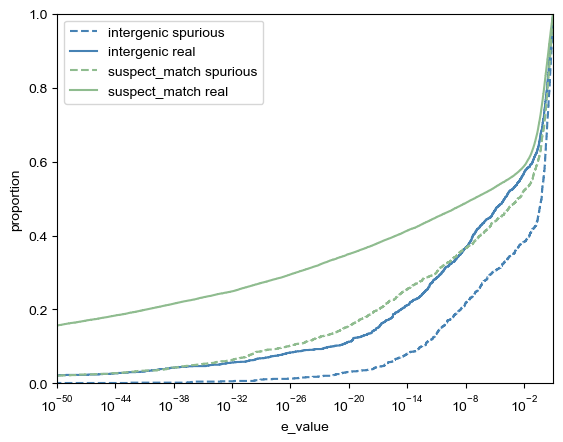

In [240]:
def figure_3(align_df, path:str=None, metric:str='e_value'):

    align_df = align_df.copy()
    # align_df['sequence_identity'] = get_sequence_identity_(align_df)

    ax_df = align_df[['e_value', 'sequence_identity', 'query_model_label', 'bit_score', 'query_name']].copy()
    ax_df = ax_df.rename(columns={'query_model_label':'model_label'})
    ax_df['model_label'] = ax_df.model_label.replace({0:'spurious', 1:'real'})

    fig, ax = plt.subplots()
    
    # palette = {'real':'darkseagreen', 'spurious':'indianred'}
    palette = {'suspect_match':'darkseagreen', 'intergenic':'steelblue'}

    for query_name, df in ax_df.groupby('query_name'):
        sns.ecdfplot(ax=ax, data=df[df.model_label == 'spurious'], linestyle='--', x=metric, color=palette.get(query_name), label=f'{query_name} spurious')
        sns.ecdfplot(ax=ax, data=df[df.model_label == 'real'], linestyle='-', x=metric, color=palette.get(query_name), label=f'{query_name} real')
    
    ax.legend()
    ax.set_ylabel('proportion')
    ax.set_xlabel(metric)

    if metric == 'e_value':
        ax.set_xscale('log', base=10)
        ax.set_xlim(xmin=1e-50, xmax=10)
    plt.show()

# figure_3(align_dfs['intergenic'])
align_df = pd.concat([align_dfs['intergenic'].assign(query_name='intergenic'), align_dfs['suspect_match'].assign(query_name='suspect_match')])
figure_3(align_df)

# A bit confused because I would have thought that the suspect matches would not have strong alignments to much,
# as then they would be annotated (and not actually suspect matches)
# I think I should ask Woody for advice on how to handle the hypothetical proteins which technically have homology support. 
# I think many of the "suspect" sequences are basically equivalent to these. 

In [183]:
# align_df = align_df[align_df.e_value < 1e-5]
# align_df = align_df.sort_values('e_value')
# align_df = align_df.drop_duplicates('query_id').set_index('query_id')
# align_df['model_output'] = results_df['model_output_0'] 
# align_df = align_df[align_df.model_output > 0.5]
# for annotation, count in align_df.subject_product.value_counts().to_dict().items():
#     print(annotation, count)

5265


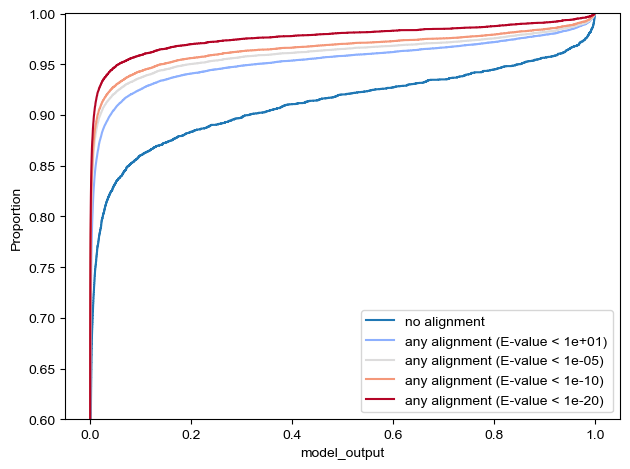

In [263]:
# First curious about the intergenic sequences, many of which I suspect are actually spurious. 
# Some are probaly actually conflicts, because of how lenient I was about the overlap length. 

# There seems to be no real correlation between overlap length and model output. 

# I was worried that the model would fail to catch some of the short, spurious ORFs that might
# not have any homology to known spurious translations. However, this does not seem to be the case. 

# What is making the model decide that some intergenic sequences are real and some are spurious?
# Do any of them bear any homology to known sequences? Could do an MMSeqs alignment against all the
# Campylobacterota sequences. 

def figure_4(results_df:pd.DataFrame, align_df:pd.DataFrame, mask_func=None, path:str=None, thresholds:list=[10, 1e-5, 1e-10, 1e-20]):

    results_df = results_df.copy()
    results_df = results_df[mask_func(results_df)].copy()
    # is_hypothetical = lambda df : df.top_hit_product.str.contains('hypothetical', flags=re.IGNORECASE) | df.top_hit_product.str.contains('Uncharacterized', flags=re.IGNORECASE)

    fig, ax = plt.subplots()

    cmap = cm.get_cmap('coolwarm')
    for i, threshold in enumerate(thresholds):
        df = align_df[(align_df.e_value < threshold) & (align_df.subject_label == 1)].copy()
        df = df.sort_values('e_value')
        df = df.drop_duplicates('query_id').set_index('query_id')

        ax_df = pd.DataFrame(index=results_df.index)
        ax_df['alignment'] = ax_df.index.isin(df.index)
        ax_df['subject_product'] = df.subject_product
        ax_df['subject_product'] = np.where(ax_df.subject_product.isnull(), 'none', ax_df.subject_product) 
        # ax_df['annotated_alignment'] = ax_df.alignment & (~ax_df.subject_product.str.contains('hypothetical'))
        ax_df['model_output'] = results_df['model_output_0']

        if threshold == 10:
            print((~ax_df.alignment).sum())
            sns.ecdfplot(ax=ax, data=ax_df[~ax_df.alignment], x='model_output', label='no alignment')

        sns.ecdfplot(ax=ax, data=ax_df[ax_df.alignment], x='model_output', label=f'any alignment (E-value < {threshold:.0e})', color=cmap((i + 1) / len(thresholds)))
        # sns.ecdfplot(ax=ax, data=ax_df[ax_df.annotated_alignment], x='model_output', linestyle='--', label=f'annotated alignment (E-value < {threshold:.0e})', color=cmap((i + 1) / len(thresholds)))

    ax.legend()
    ax.set_ylim(ymin=0.6)

    fig.tight_layout()
    plt.show()


# What are all of these sequences with strong alignments to something in the training set, but predicted to be spurious?
figure_4(results_df, align_dfs['suspect_match'], mask_func=is_suspect_match)
# figure_4(results_df, align_dfs['intergenic'], mask_func=is_intergenic)
    

In [111]:
ax_df[ax_df.alignment & (ax_df.model_output > 0.5)]

,alignment,subject_product,annotated_alignment,model_output,sequence_identity,e_value,query_seq,subject_seq
id,,,,,,,,
NZ_CP087125.1_313,True,hydrogenase maturation protein,True,0.998922,0.183,1.919000e-24,MHTEFWSATSDFHTLRHKFVYKVCPRETPERLKLRSNKESVYA,MKILLMCSVFNSLTQAVYTVLIDKGHQVSVAYAISEVQMLTEIEDF...
NZ_CP011308.1_1685,True,hypothetical protein,False,0.996575,0.448,4.517000e-22,MTPLINRLIDAVQSAPILQQRVCLCNCFYKSKARLVLLLNHFIPRC...,MLRGFGKNYFTLSAILAHSVAQKLQAQVSSAQTLFLLSNDKEPLED...
NZ_AP023046.1_1647,True,N-6 DNA methylase,True,0.974978,0.157,7.951000e-30,MIKGTTAHEHLRLAKDIDKLLGINKAASTPELVVPDWDEAQKEQIH...,MWKDMSLPERKSAFTHFKAQELVAHLKSQHIRLDQAQSLEKAYNPS...
NZ_MDSU01000007.1_1,True,IS200/IS605 family accessory protein TnpB-rela...,True,0.974792,0.290,1.787000e-29,FEWLKNSLFKLCNPIKIKSDYEFCKFLKNMQNSVSGKSVLWANQST...,PFKHYNAKFNRILSKLNESKSQEVLEWGTSKTNTKYPLKYTQRGKD...
NZ_MDSU01000016.1_46,True,IS200/IS605 family accessory protein TnpB-rela...,True,0.991471,0.918,2.190000e-21,MRTTLKKNDINSNEELRTLSIRINSIKLNKKILSLVYSYRHFEN,MRTTLKKNDINSNEELRTLSIRINSIKLNKKILSLVYSYRHFENIL...
NZ_UGJE01000002.1_1629,True,Abi-alpha family protein,True,0.901706,0.296,2.061000e-21,MRINENGIYEEECIEVSYHINKDFFAIYKNHLTLLGLLTGSYYQQT...,MAINFDLTEAYKDILQPSAQQAGVTLGEIAKLILAPIYYPTKTLND...
NZ_JANZKZ010000006.1_59,True,hypothetical protein,False,0.929351,0.900,6.827000e-24,MKLTPYSQNSFTPIPSKFTIFMRTCVIWQLIKFIMINIRMTILILKSHH,MKLTPYSQNAFTPIPSKFTLFRRTCVIWQVIKFIMINIRMTILIIKSHH
NZ_AUPZ01000002.1_156,True,GNAT family N-acyltransferase,True,0.638958,0.347,2.370000e-29,MYIKMNQLDIEYTYGALESSFLRLLKIYKMNYVKIGNEQVHKYFGF...,MNFTFLEVKDSNLLEDVFKFRYKILLEIYPEYLQNLNLSEEKEYDK...
NZ_KI912401.1_515,True,membrane protein insertion efficiency factor YidD,True,0.792055,0.712,4.455000e-51,MIGMMRWVVSRFFIAIIVFYRLFISPLKRPSCRFYPSCSSYSLTLF...,MRQLFILMIEFYRRYVSPLKRPSCRFYPSCSSYSLMLFRLTHPLYA...


In [ ]:
    # ax_a_df = results_df[['model_output_0', 'overlap_length', 'top_hit_overlap_fraction', 'query_overlap_fraction', 'same_strand', 'top_hit_feature']].copy()
    # ax_a_df = ax_a_df[ax_a_df.overlap_length > 0].copy()
    # ax_a_df['top_hit_feature'] = ax_a_df.top_hit_feature.replace({'rRNA':'RNA', 'tRNA':'RNA', 'ncRNA':'RNA'})
    # hue_order = ['CDS', 'RNA', 'repeat_region', 'misc_feature', 'regulatory']
    # ax_a_df = ax_a_df.sort_values('top_hit_feature', key=np.vectorize(hue_order.index))
    # ax_a_df['overlap_length'] += np.random.uniform(low=-1, high=1, size=len(ax_a_df)) * 0.5

    # palette = {'CDS':'darkseagreen', 'RNA':'indianred', 'repeat_region':'steelblue', 'misc_feature':'dimgray', 'regulatory':'steelblue'}
    # sns.scatterplot(data=ax_a_df, x='overlap_length', y='model_output_0', hue='top_hit_feature', palette=palette)

    # ax_a_df = pd.DataFrame(index=np.arange(len(results_df) + len(antifam_df)))
    # ax_a_df['length'] = list(results_df.query_seq.apply(len)) + list(antifam_df.seq.apply(len))
    # ax_a_df['source'] = list(np.where(results_df.model_label == 0, 'intergenic spurious', 'intergenic real')) + ['AntiFam'] * len(antifam_df)
    # sns.kdeplot(data=ax_a_df, x='length', hue='source', common_norm=False, ax=ax)
